In [1]:
import numpy as np
np.random.seed(1)
import random as rn
rn.seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import os
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import math
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

In [2]:
def mean_abs_pct_error(y, y_pred, **kwargs):
    arr = abs(y_pred - y) / y
    return np.mean(arr)

In [3]:
engine = config.engine

In [4]:
train_qry = 'SELECT * FROM train_cleaned;'
train = pd.read_sql(sql=train_qry, con=engine)

In [5]:
test_qry = 'SELECT * FROM test_cleaned;'
test = pd.read_sql(sql=test_qry, con=engine)

In [6]:
train.columns

Index(['transaction_date', 'postcode', 'ptype', 'new_build',
       'energy_consumption_current', 'energy_consumption_potential',
       'total_floor_area', 'mains_gas_flag', 'glazed_type', 'extension_count',
       'number_open_fireplaces', 'mainheat_energy_eff', 'mainheatc_energy_eff',
       'construction_age_band', 'lsoa_code', 'barriers_score', 'cyp_score',
       'indoors_score', 'pop_16_59', 'older_pop_60', 'price', 'bungalow_flag'],
      dtype='object')

In [7]:
y_train = train['price'].apply(np.log)
y_test = test['price'].apply(np.log)
train = train.drop(['transaction_date', 'postcode', 'price', 'lsoa_code'], axis=1)
test = test.drop(['transaction_date', 'postcode', 'price', 'lsoa_code'], axis=1)

In [8]:
train.columns

Index(['ptype', 'new_build', 'energy_consumption_current',
       'energy_consumption_potential', 'total_floor_area', 'mains_gas_flag',
       'glazed_type', 'extension_count', 'number_open_fireplaces',
       'mainheat_energy_eff', 'mainheatc_energy_eff', 'construction_age_band',
       'barriers_score', 'cyp_score', 'indoors_score', 'pop_16_59',
       'older_pop_60', 'bungalow_flag'],
      dtype='object')

In [9]:
combined_data = pd.get_dummies(pd.concat([train, test]), drop_first=True)
X_train = combined_data[:len(train)]
X_test = combined_data[len(train):]
X_cols = X_train.columns
X_train.head()

,energy_consumption_current,energy_consumption_potential,total_floor_area,extension_count,number_open_fireplaces,mainheat_energy_eff,mainheatc_energy_eff,barriers_score,cyp_score,indoors_score,...,construction_age_band_England and Wales: 1930-1949,construction_age_band_England and Wales: 1950-1966,construction_age_band_England and Wales: 1967-1975,construction_age_band_England and Wales: 1976-1982,construction_age_band_England and Wales: 1983-1990,construction_age_band_England and Wales: 1991-1995,construction_age_band_England and Wales: 1996-2002,construction_age_band_England and Wales: 2003-2006,construction_age_band_England and Wales: 2007 onwards,construction_age_band_England and Wales: before 1900
0,377,269,64.96,0.0,0.0,1,1,21.025,0.314,0.448,...,0,0,1,0,0,0,0,0,0,0
1,275,68,86.00,1.0,0.0,3,2,23.975,-0.325,0.694,...,0,0,0,0,0,0,0,0,0,1
2,175,165,84.48,0.0,0.0,4,3,16.241,0.718,-1.119,...,0,0,1,0,0,0,0,0,0,0
3,327,194,106.00,2.0,0.0,3,3,21.025,0.314,0.448,...,1,0,0,0,0,0,0,0,0,0
4,154,69,130.00,2.0,0.0,3,3,8.620,-1.121,-1.210,...,0,1,0,0,0,0,0,0,0,0


In [10]:
X_train.loc[:, 'total_floor_area'] = X_train.loc[:, 'total_floor_area'].apply(np.log)
X_test.loc[:, 'total_floor_area'] = X_test.loc[:, 'total_floor_area'].apply(np.log)

C:\Users\neils\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
X_train.shape

(1796, 33)

In [12]:
X_test.shape

(771, 33)

In [13]:
scale = MinMaxScaler()

In [14]:
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [15]:
np.random.seed(1)
kfold = KFold(5)

In [16]:
lr = LinearRegression()
lr_selector = RFECV(estimator=lr, min_features_to_select=4, cv=kfold, scoring='r2')
lr_selector.fit(X_train_scaled, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=4, n_jobs=None, scoring='r2', step=1, verbose=0)

In [17]:
lr_selector.support_

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False,  True, False,  True,  True,  True])

In [18]:
cols = X_train.loc[:, lr_selector.support_].columns
cols

Index(['energy_consumption_current', 'energy_consumption_potential',
       'total_floor_area', 'number_open_fireplaces', 'mainheat_energy_eff',
       'mainheatc_energy_eff', 'barriers_score', 'cyp_score', 'indoors_score',
       'pop_16_59', 'older_pop_60', 'bungalow_flag', 'ptype_F', 'ptype_S',
       'ptype_T', 'new_build_Y', 'mains_gas_flag_Y',
       'glazed_type_double glazing installed during or after 2002',
       'glazed_type_secondary glazing', 'glazed_type_single glazing',
       'construction_age_band_England and Wales: 1967-1975',
       'construction_age_band_England and Wales: 1991-1995',
       'construction_age_band_England and Wales: 2003-2006',
       'construction_age_band_England and Wales: 2007 onwards',
       'construction_age_band_England and Wales: before 1900'],
      dtype='object')

In [19]:
len(cols)

25

In [20]:
train_selected = X_train_scaled[:, lr_selector.support_]
test_selected = X_test_scaled[:, lr_selector.support_]

In [21]:
lr.fit(train_selected, y_train)
lr_y_train_pred = lr.predict(train_selected)
lr_y_test_pred = lr.predict(test_selected)

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score

In [106]:
lr25_test_mae = mean_absolute_error(y_test, lr_y_test_pred)
lr25_test_r2 = r2_score(y_test, lr_y_test_pred)
print(f'Test MAE: {lr25_test_mae}')
print(f'Test r2: {lr25_test_r2}')

Test MAE: 0.11429587161735709
Test r2: 0.8478517689476766


In [107]:
lr25_adj_r2 = 1 - (1 - lr_test_r2)*(len(test.index) - 1) / (len(test.index) - len(test_selected[0]) - 1)
lr25_adj_r2

0.8427461236103503

In [108]:
coefs = pd.DataFrame.from_records(list(zip(cols, lr.coef_)), columns=['feature', 'coefficient'])
coefs

,feature,coefficient
0,energy_consumption_current,-0.054560
1,energy_consumption_potential,-0.100628
2,total_floor_area,1.708971
3,number_open_fireplaces,0.102516
4,mainheat_energy_eff,0.069742
5,mainheatc_energy_eff,0.128472
6,barriers_score,-0.068119
7,cyp_score,-0.178986
8,indoors_score,-0.044786
9,pop_16_59,-0.030708


In [26]:
reduced_cols = list(coefs.loc[coefs['coefficient'].abs() >= 0.05, 'feature'])

In [27]:
reduced_cols

['energy_consumption_current',
 'energy_consumption_potential',
 'total_floor_area',
 'number_open_fireplaces',
 'mainheat_energy_eff',
 'mainheatc_energy_eff',
 'barriers_score',
 'cyp_score',
 'older_pop_60',
 'ptype_F',
 'ptype_S',
 'ptype_T',
 'new_build_Y',
 'mains_gas_flag_Y',
 'glazed_type_single glazing',
 'construction_age_band_England and Wales: before 1900']

In [28]:
X_train[reduced_cols].corr()

,energy_consumption_current,energy_consumption_potential,total_floor_area,number_open_fireplaces,mainheat_energy_eff,mainheatc_energy_eff,barriers_score,cyp_score,older_pop_60,ptype_F,ptype_S,ptype_T,new_build_Y,mains_gas_flag_Y,glazed_type_single glazing,construction_age_band_England and Wales: before 1900
energy_consumption_current,1.000000,0.620353,-0.265409,0.170670,-0.378491,-0.507312,-0.094760,0.083937,-0.044856,-0.122558,0.120931,0.020630,-0.445065,-0.377903,0.122191,0.135120
energy_consumption_potential,0.620353,1.000000,-0.352705,0.094609,-0.522616,-0.399550,0.051190,0.160234,-0.108250,0.301618,-0.125623,-0.095327,-0.246744,-0.628262,0.103957,0.057649
total_floor_area,-0.265409,-0.352705,1.000000,0.201314,0.302931,0.323452,-0.214258,-0.411385,0.280282,-0.562283,0.120463,-0.079022,0.000497,0.383733,-0.054365,-0.048063
number_open_fireplaces,0.170670,0.094609,0.201314,1.000000,0.091331,0.029148,-0.075890,-0.091715,0.100292,-0.198673,0.072895,-0.061505,-0.082822,0.104351,0.049116,0.120561
mainheat_energy_eff,-0.378491,-0.522616,0.302931,0.091331,1.000000,0.220988,-0.124589,-0.137897,0.085633,-0.318235,0.140039,0.074962,0.075620,0.788801,-0.030705,0.017239
mainheatc_energy_eff,-0.507312,-0.399550,0.323452,0.029148,0.220988,1.000000,-0.064467,-0.186934,0.179097,-0.209639,0.012760,0.024163,0.077082,0.304441,-0.009162,-0.049907
barriers_score,-0.094760,0.051190,-0.214258,-0.075890,-0.124589,-0.064467,1.000000,0.380342,-0.350465,0.275914,-0.094312,-0.021248,0.223756,-0.160470,-0.017528,-0.068224
cyp_score,0.083937,0.160234,-0.411385,-0.091715,-0.137897,-0.186934,0.380342,1.000000,-0.600055,0.279233,0.010474,0.067454,0.026537,-0.176779,0.013902,-0.003538
older_pop_60,-0.044856,-0.108250,0.280282,0.100292,0.085633,0.179097,-0.350465,-0.600055,1.000000,-0.223798,0.024426,-0.063293,-0.056660,0.128978,-0.018482,0.021091
ptype_F,-0.122558,0.301618,-0.562283,-0.198673,-0.318235,-0.209639,0.275914,0.279233,-0.223798,1.000000,-0.419106,-0.263827,0.294475,-0.417907,-0.023266,-0.060902


In [29]:
reduced_cols = X_train[reduced_cols].drop(['energy_consumption_potential',
                                      'mainheat_energy_eff',
                                      'glazed_type_single glazing',], axis=1).columns
reduced_cols

Index(['energy_consumption_current', 'total_floor_area',
       'number_open_fireplaces', 'mainheatc_energy_eff', 'barriers_score',
       'cyp_score', 'older_pop_60', 'ptype_F', 'ptype_S', 'ptype_T',
       'new_build_Y', 'mains_gas_flag_Y',
       'construction_age_band_England and Wales: before 1900'],
      dtype='object')

In [30]:
X_train_reduced = scale.fit_transform(X_train[reduced_cols])
X_test_reduced = scale.transform(X_test[reduced_cols])

In [103]:
lr_r = LinearRegression()
lr_r.fit(X_train_reduced, y_train)
lr13_y_train_pred = lr_r.predict(X_train_reduced)
lr13_y_test_pred = lr_r.predict(X_test_reduced)

In [104]:
lr13_test_mae = mean_absolute_error(y_test, lr_y_test_pred_r)
lr13_test_r2 = r2_score(y_test, lr_y_test_pred_r)
print(f'Test MAE: {lr_test_mae_r}')
print(f'Test r2: {lr_test_r2_r}')

Test MAE: 0.11279663807037749
Test r2: 0.8495269277883615


In [105]:
lr13_adj_r2 = 1 - (1 - lr_test_r2_r)*(len(X_test_reduced) - 1) / (len(X_test_reduced) - len(X_test_reduced[0]) - 1)
lr13_adj_r2

0.8469428459670255

In [34]:
reduced_cols

Index(['energy_consumption_current', 'total_floor_area',
       'number_open_fireplaces', 'mainheatc_energy_eff', 'barriers_score',
       'cyp_score', 'older_pop_60', 'ptype_F', 'ptype_S', 'ptype_T',
       'new_build_Y', 'mains_gas_flag_Y',
       'construction_age_band_England and Wales: before 1900'],
      dtype='object')

In [35]:
coefs_r = pd.DataFrame.from_records(list(zip(reduced_cols, lr_r.coef_)), columns=['feature', 'coefficient'])
coefs_r

,feature,coefficient
0,energy_consumption_current,-0.138235
1,total_floor_area,1.678863
2,number_open_fireplaces,0.112167
3,mainheatc_energy_eff,0.123792
4,barriers_score,-0.090625
5,cyp_score,-0.199376
6,older_pop_60,0.122135
7,ptype_F,-0.397136
8,ptype_S,-0.170198
9,ptype_T,-0.234404


In [36]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [37]:
def create_model(neurons=4, act='relu', opt='adam', loss='mean_absolute_error', dropout_rate=0, kernel='uniform'):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(n_inputs,)))
    model.add(Dense(neurons, activation=act))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [38]:
batch_size = [10, 20, 50]
epochs = [100]
neurons = [8, 16, 32, 64, 128, 256]

params = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)
params

{'batch_size': [10, 20, 50],
 'epochs': [100],
 'neurons': [8, 16, 32, 64, 128, 256]}

### 25 Features ANN

In [39]:
n_inputs = train_selected.shape[1]

In [40]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
model = KerasRegressor(build_fn=create_model, verbose=0)

gs = GridSearchCV(estimator=model, param_grid=params, cv=kfold, n_jobs=-1)
cv25 = gs.fit(train_selected, y_train)

cv25.best_params_

{'batch_size': 20, 'epochs': 100, 'neurons': 128}

In [41]:
cv25.best_score_

-0.1267141755048851

In [42]:
bp25 = cv25.best_params_
neurons = bp25['neurons']
dropout_rate = 0
batch_size = bp25['batch_size']
model = create_model(neurons=neurons, dropout_rate=dropout_rate)
epochs = 300

In [43]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
model = create_model(neurons=neurons, dropout_rate=dropout_rate)

ann25_history = model.fit(
    train_selected,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=2
)

Train on 1436 samples, validate on 360 samples
Epoch 1/300
 - 0s - loss: 8.8117 - val_loss: 3.5224
Epoch 2/300
 - 0s - loss: 1.4053 - val_loss: 1.0701
Epoch 3/300
 - 0s - loss: 0.9712 - val_loss: 0.8583
Epoch 4/300
 - 0s - loss: 0.8059 - val_loss: 0.7008
Epoch 5/300
 - 0s - loss: 0.6785 - val_loss: 0.5946
Epoch 6/300
 - 0s - loss: 0.5938 - val_loss: 0.5552
Epoch 7/300
 - 0s - loss: 0.5439 - val_loss: 0.5523
Epoch 8/300
 - 0s - loss: 0.5171 - val_loss: 0.5296
Epoch 9/300
 - 0s - loss: 0.4886 - val_loss: 0.4582
Epoch 10/300
 - 0s - loss: 0.4708 - val_loss: 0.4610
Epoch 11/300
 - 0s - loss: 0.4545 - val_loss: 0.4456
Epoch 12/300
 - 0s - loss: 0.4365 - val_loss: 0.4751
Epoch 13/300
 - 0s - loss: 0.4332 - val_loss: 0.4056
Epoch 14/300
 - 0s - loss: 0.4091 - val_loss: 0.4018
Epoch 15/300
 - 0s - loss: 0.3935 - val_loss: 0.3860
Epoch 16/300
 - 0s - loss: 0.3868 - val_loss: 0.3811
Epoch 17/300
 - 0s - loss: 0.3718 - val_loss: 0.3609
Epoch 18/300
 - 0s - loss: 0.3624 - val_loss: 0.3532
Epoch 19

Epoch 154/300
 - 0s - loss: 0.1012 - val_loss: 0.1421
Epoch 155/300
 - 0s - loss: 0.1030 - val_loss: 0.1342
Epoch 156/300
 - 0s - loss: 0.1020 - val_loss: 0.1361
Epoch 157/300
 - 0s - loss: 0.1067 - val_loss: 0.1346
Epoch 158/300
 - 0s - loss: 0.1026 - val_loss: 0.1318
Epoch 159/300
 - 0s - loss: 0.1213 - val_loss: 0.1372
Epoch 160/300
 - 0s - loss: 0.1074 - val_loss: 0.1366
Epoch 161/300
 - 0s - loss: 0.1028 - val_loss: 0.1308
Epoch 162/300
 - 0s - loss: 0.1122 - val_loss: 0.1324
Epoch 163/300
 - 0s - loss: 0.1023 - val_loss: 0.1332
Epoch 164/300
 - 0s - loss: 0.1054 - val_loss: 0.1773
Epoch 165/300
 - 0s - loss: 0.1076 - val_loss: 0.1301
Epoch 166/300
 - 0s - loss: 0.1007 - val_loss: 0.1499
Epoch 167/300
 - 0s - loss: 0.1028 - val_loss: 0.1354
Epoch 168/300
 - 0s - loss: 0.1149 - val_loss: 0.1462
Epoch 169/300
 - 0s - loss: 0.0990 - val_loss: 0.1374
Epoch 170/300
 - 0s - loss: 0.1057 - val_loss: 0.1592
Epoch 171/300
 - 0s - loss: 0.1011 - val_loss: 0.1310
Epoch 172/300
 - 0s - loss: 

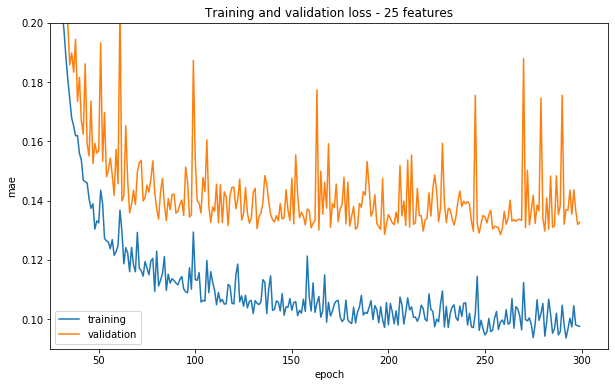

In [80]:
plt.figure(figsize=(10,6))
plt.plot(ann25_history.history['loss'])
plt.plot(ann25_history.history['val_loss'])
plt.title('Training and validation loss - 25 features')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['training', 'validation'])
plt.ylim((0.09,0.2))
plt.xlim(25)
plt.savefig('figures/baseline_ann_train_val_loss_history_25_features.png')
plt.show()

In [45]:
n_inputs = train_selected.shape[1]

In [46]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
best_epochs = 100
model = create_model(neurons=neurons, dropout_rate=dropout_rate)
model.fit(train_selected, y_train, batch_size=batch_size, epochs=best_epochs, verbose=0)
ann25_y_test_pred = model.predict(test_selected)

In [123]:
ann25_test_mae = mean_absolute_error(y_test, ann25_y_test_pred)
ann25_test_r2 = r2_score(y_test, ann25_y_test_pred)
print(f'Test MAE: {ann25_test_mae}')
print(f'Test r2: {ann25_test_r2}')

Test MAE: 0.12349530026518665
Test r2: 0.8390149845468338


In [102]:
ann25_adj_r2 = 1 - (1 - ann25_test_r2_r)*(len(test_selected) - 1) / (len(test_selected) - len(test_selected[0]) - 1)
ann25_adj_r2

0.8336128028202174

In [49]:
# Ensemble
n_inputs = train_selected.shape[1]

ensemble25_y_test_pred = []

best_epochs = 100

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i = 0
while i < 10:
    model = create_model(neurons=neurons, dropout_rate=dropout_rate)
    history = model.fit(train_selected, y_train, batch_size=batch_size, epochs=best_epochs, verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict(test_selected)
        ensemble25_y_test_pred.append(y_pred)
        i += 1
    else:
        continue

In [51]:
ensemble25_y_test_pred_mean = np.array(ensemble25_y_test_pred).mean(axis=0).reshape(-1,1)

In [109]:
ensemble25_test_mae = mean_absolute_error(y_test, ensemble25_y_test_pred_mean)
ensemble25_test_r2 = r2_score(y_test, ensemble25_y_test_pred_mean)
print(f'Test MAE: {ensemble25_test_mae}')
print(f'Test r2: {ensemble25_test_r2}')

Test MAE: 0.11165599008907885
Test r2: 0.8459467509053105


In [110]:
ensemble25_adj_r2 = 1 - (1 - ensemble25_test_r2_r)*(len(test_selected) - 1) / (len(test_selected) - len(test_selected[0]) - 1)
ensemble25_adj_r2

0.840777178788039

### 13 features ANN

In [56]:
n_inputs = X_train_reduced.shape[1]

In [57]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
model = KerasRegressor(build_fn=create_model, verbose=0)
gs = GridSearchCV(estimator=model, param_grid=params, cv=kfold, n_jobs=-1)
cv13 = gs.fit(X_train_reduced, y_train)

C:\Users\neils\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [58]:
cv13.best_params_

{'batch_size': 10, 'epochs': 100, 'neurons': 64}

In [59]:
cv13.best_score_

-0.11787678180870645

In [60]:
bp13 = cv13.best_params_
neurons = bp13['neurons']
batch_size = bp13['batch_size']
epochs = 300

In [61]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
model = create_model(neurons=neurons, dropout_rate=dropout_rate)

ann13_history = model.fit(
    X_train_reduced,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=2
)

Train on 1436 samples, validate on 360 samples
Epoch 1/300
 - 0s - loss: 8.6949 - val_loss: 2.0847
Epoch 2/300
 - 0s - loss: 1.1504 - val_loss: 1.0126
Epoch 3/300
 - 0s - loss: 0.9365 - val_loss: 0.8354
Epoch 4/300
 - 0s - loss: 0.7941 - val_loss: 0.6951
Epoch 5/300
 - 0s - loss: 0.6930 - val_loss: 0.6059
Epoch 6/300
 - 0s - loss: 0.5999 - val_loss: 0.5503
Epoch 7/300
 - 0s - loss: 0.5371 - val_loss: 0.4955
Epoch 8/300
 - 0s - loss: 0.4942 - val_loss: 0.4604
Epoch 9/300
 - 0s - loss: 0.4590 - val_loss: 0.4278
Epoch 10/300
 - 0s - loss: 0.4231 - val_loss: 0.4237
Epoch 11/300
 - 0s - loss: 0.4026 - val_loss: 0.3872
Epoch 12/300
 - 0s - loss: 0.3707 - val_loss: 0.3541
Epoch 13/300
 - 0s - loss: 0.3528 - val_loss: 0.3353
Epoch 14/300
 - 0s - loss: 0.3294 - val_loss: 0.3247
Epoch 15/300
 - 0s - loss: 0.3079 - val_loss: 0.3008
Epoch 16/300
 - 0s - loss: 0.2924 - val_loss: 0.2887
Epoch 17/300
 - 0s - loss: 0.2738 - val_loss: 0.2549
Epoch 18/300
 - 0s - loss: 0.2535 - val_loss: 0.2407
Epoch 19

Epoch 154/300
 - 0s - loss: 0.1103 - val_loss: 0.1326
Epoch 155/300
 - 0s - loss: 0.1118 - val_loss: 0.1352
Epoch 156/300
 - 0s - loss: 0.1107 - val_loss: 0.1418
Epoch 157/300
 - 0s - loss: 0.1137 - val_loss: 0.1626
Epoch 158/300
 - 0s - loss: 0.1144 - val_loss: 0.1503
Epoch 159/300
 - 0s - loss: 0.1112 - val_loss: 0.1328
Epoch 160/300
 - 0s - loss: 0.1134 - val_loss: 0.1303
Epoch 161/300
 - 0s - loss: 0.1137 - val_loss: 0.1354
Epoch 162/300
 - 0s - loss: 0.1135 - val_loss: 0.1308
Epoch 163/300
 - 0s - loss: 0.1148 - val_loss: 0.1482
Epoch 164/300
 - 0s - loss: 0.1148 - val_loss: 0.1381
Epoch 165/300
 - 0s - loss: 0.1127 - val_loss: 0.1331
Epoch 166/300
 - 0s - loss: 0.1134 - val_loss: 0.1461
Epoch 167/300
 - 0s - loss: 0.1123 - val_loss: 0.1344
Epoch 168/300
 - 0s - loss: 0.1182 - val_loss: 0.1342
Epoch 169/300
 - 0s - loss: 0.1116 - val_loss: 0.1338
Epoch 170/300
 - 0s - loss: 0.1119 - val_loss: 0.1420
Epoch 171/300
 - 0s - loss: 0.1178 - val_loss: 0.1365
Epoch 172/300
 - 0s - loss: 

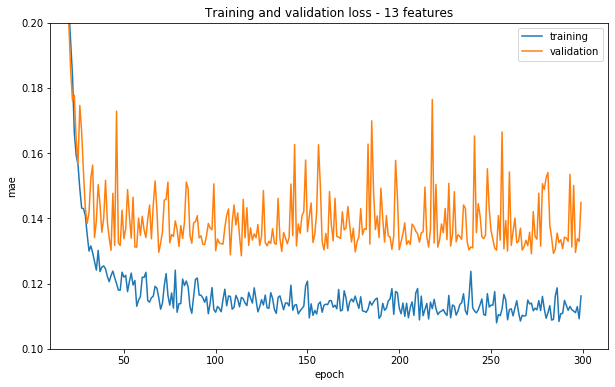

In [82]:
plt.figure(figsize=(10,6))
plt.plot(ann13_history.history['loss'])
plt.plot(ann13_history.history['val_loss'])
plt.title('Training and validation loss - 13 features')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['training', 'validation'])
plt.ylim((0.1, 0.2))
plt.xlim(10)
plt.savefig('figures/baseline_ann_train_val_loss_history_13_features.png')
plt.show()

In [158]:
# Ensemble
n_inputs = X_train_reduced.shape[1]

In [177]:
tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
best_epochs = 100
model = create_model(neurons=neurons, dropout_rate=dropout_rate)
model.fit(X_train_reduced, y_train, batch_size=batch_size, epochs=best_epochs, verbose=0)
ann13_y_test_pred = model.predict(X_test_reduced)

In [178]:
ann13_test_mae = mean_absolute_error(y_test, ann13_y_test_pred)
ann13_test_r2 = r2_score(y_test, ann13_y_test_pred)
print(f'Test MAE: {ann13_test_mae_r}')
print(f'Test r2: {ann13_test_r2_r}')

Test MAE: 0.12351314859234139
Test r2: 0.8264480437730141


In [179]:
ann13_adj_r2 = 1 - (1 - ann13_test_r2)*(len(test_selected) - 1) / (len(test_selected) - len(test_selected[0]) - 1)
ann13_adj_r2

0.8203191972779997

#### Ensemble with 13 features

In [188]:
ensemble13_y_test_pred = []

best_epochs = 100

tf.random.set_seed(2)
np.random.seed(1)
rn.seed(1)
i=0
while i < 10:
    model = create_model(neurons=neurons, dropout_rate=dropout_rate)
    model.fit(X_train_reduced, y_train, batch_size=batch_size, epochs=best_epochs, verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict(X_test_reduced)
        ensemble13_y_test_pred.append(y_pred)
        i += 1
    else:
        continue

In [189]:
ensemble13_y_test_pred_mean = np.array(ensemble13_y_test_pred).mean(axis=0)

In [191]:
ensemble13_test_mae = mean_absolute_error(y_test, ensemble13_y_test_pred_mean)
ensemble13_test_r2 = r2_score(y_test, ensemble13_y_test_pred_mean)
print(f'Test MAE: {ensemble13_test_mae}')
print(f'Test r2: {ensemble13_test_r2}')

Test MAE: 0.11495577810995304
Test r2: 0.8259358563123705


In [192]:
ensemble13_adj_r2 = 1 - (1 - ensemble13_test_r2_r)*(len(X_test_reduced) - 1) / (len(X_test_reduced) - len(X_test_reduced[0]) - 1)
ensemble13_adj_r2

0.8311128698595798

### 13 features random forest

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [94]:
np.random.seed(1)
rf = RandomForestRegressor()
min_samples_leaf=[1, 3, 5]
n_estimators = [50, 100, 200]
max_depth = [None, 5, 10, 15, 20]
params = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

cv = GridSearchCV(rf, cv=kfold, scoring='r2', param_grid=params, n_jobs=-1)
cv.fit(X_train_reduced, y_train)
cv.best_score_


0.8445293642538921

In [95]:
cv.best_params_

{'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}

In [120]:
best_estimators = cv.best_params_['n_estimators']
best_depth = cv.best_params_['max_depth']
best_min_samples = cv.best_params_['min_samples_leaf']


np.random.seed(1)
rf = RandomForestRegressor(n_estimators=best_estimators,
                           max_depth=best_depth,
                           min_samples_leaf=best_min_samples)

rf.fit(X_train_reduced, y_train)
rf13_y_pred = rf.predict(X_test_reduced)
rf13_test_mae = mean_absolute_error(y_test, rf13_y_pred)
rf13_test_r2 = r2_score(y_test, rf13_y_pred)
print(f'Test MAE: {rf_mae}')
print(f'Test r2: {rf_r2}')

Test MAE: 0.10354903529311382
Test r2: 0.8568271507109988


In [121]:
rf13_adj_r2 = 1- (1 - rf13_test_r2) * (len(X_test_reduced) - 1) / (len(X_test_reduced) - len(X_test_reduced[0]) - 1)
rf13_adj_r2

0.8553915751284087

### 25 features random forest

In [98]:
np.random.seed(1)
rf = RandomForestRegressor()
min_samples_leaf=[1, 3, 5]
n_estimators = [50, 100, 200]
max_depth = [None, 5, 10, 15, 20]
params = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

cv = GridSearchCV(rf, cv=kfold, scoring='r2', param_grid=params, n_jobs=-1)
cv.fit(train_selected, y_train)
cv.best_score_


0.8443522193359498

In [99]:
cv.best_params_

{'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 200}

In [113]:
best_estimators = cv.best_params_['n_estimators']
best_depth = cv.best_params_['max_depth']
best_min_samples = cv.best_params_['min_samples_leaf']


np.random.seed(1)
rf = RandomForestRegressor(n_estimators=best_estimators,
                           max_depth=best_depth,
                           min_samples_leaf=best_min_samples)

rf.fit(train_selected, y_train)
rf25_y_pred = rf.predict(test_selected)
rf25_test_mae = mean_absolute_error(y_test, rf25_y_pred)
rf25_test_r2 = r2_score(y_test, rf25_y_pred)
print(f'Test MAE: {rf_mae}')
print(f'Test r2: {rf_r2}')

Test MAE: 0.10354903529311382
Test r2: 0.8568271507109988


In [155]:
rf25_adj_r2 = 1- (1 - rf25_test_r2) * (len(train_selected) - 1) / (len(train_selected) - len(train_selected[0]) - 1)
rf25_adj_r2

0.8548049353255609

In [198]:
features = [25, 13] * 4
model_names = ['OLS', 'OLS', 'Random Forest', 'Random Forest',
               'ANN', 'ANN', 'ANN Ensemble', 'ANN Ensemble']
maes = np.array([lr25_test_mae, lr13_test_mae, rf25_test_mae, rf13_test_mae,
        ann25_test_mae, ann13_test_mae, ensemble25_test_mae, ensemble13_test_mae]).round(3)

r2s = np.array([lr25_test_r2, lr13_test_r2, rf25_test_r2, rf13_test_r2,
       ann25_test_r2, ann13_test_r2, ensemble25_test_r2, ensemble13_test_r2]).round(3)

adj_r2s = np.array([lr25_adj_r2, lr13_adj_r2, rf25_adj_r2, rf13_adj_r2,
           ann25_adj_r2, ann13_adj_r2, ensemble25_adj_r2, ensemble13_adj_r2]).round(3)

In [199]:
pd.DataFrame.from_records(list(zip(features, maes, r2s, adj_r2s)),
                          index=model_names,
                          columns=['features',
                                  'mae',
                                  'r-squared',
                                  'adjusted r-squared']
                         )

,features,mae,r-squared,adjusted r-squared
OLS,25,0.114,0.848,0.843
OLS,13,0.113,0.850,0.847
Random Forest,25,0.104,0.857,0.855
Random Forest,13,0.103,0.858,0.855
ANN,25,0.123,0.839,0.834
ANN,13,0.123,0.826,0.820
ANN Ensemble,25,0.112,0.846,0.841
ANN Ensemble,13,0.115,0.826,0.831


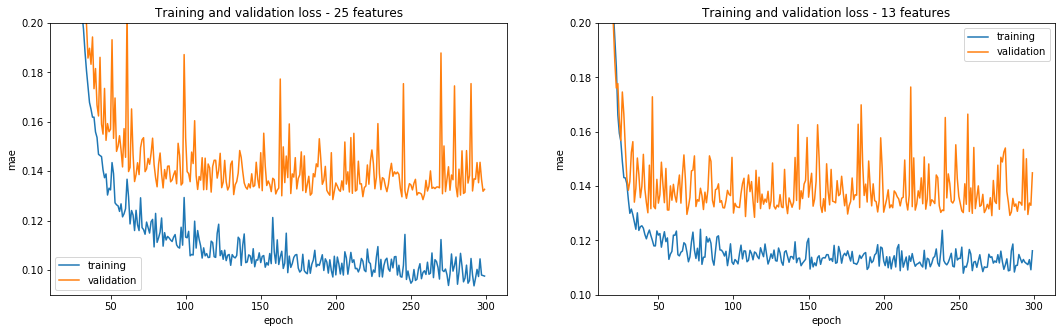

In [195]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(ann25_history.history['loss'])
plt.plot(ann25_history.history['val_loss'])
plt.title('Training and validation loss - 25 features')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['training', 'validation'])
plt.ylim((0.09,0.2))
plt.xlim(10)
plt.subplot(122)
plt.plot(ann13_history.history['loss'])
plt.plot(ann13_history.history['val_loss'])
plt.title('Training and validation loss - 13 features')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['training', 'validation'])
plt.ylim((0.1, 0.2))
plt.xlim(10)
plt.savefig('figures/baseline_ann_train_val_loss_history_both.png')
plt.show()